In [2]:
import sys

sys.path.append("../")

In [4]:
import pandas as pd
import numpy as np
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from stats_arb.tests import adf_test, kpss_test, cal_half_life, pp_test
from datetime import datetime, timedelta
from ta.volatility import BollingerBands

import matplotlib.pyplot as plt


In [5]:
import requests
import json
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt


def to_dataframe(json_data):
    df = pd.DataFrame(json_data, columns=['OpenTime', 'Open', 'High', 'Low', 'Close', 'Volume', 'CloseTime', 'BaseAssetVolume', 'NbTrades', 'TakerBuyVol', 'TakerBuyBaseAssetVol', 'Ignore'])
    df.drop(columns=['CloseTime', 'BaseAssetVolume', 'NbTrades', 'TakerBuyVol', 'TakerBuyBaseAssetVol', 'Ignore'], inplace=True)
    df['OpenTime'] = pd.to_datetime(df['OpenTime'], unit='ms')
    df.set_index(keys=['OpenTime'], inplace=True)

    df[['Open', 'High', 'Low', 'Close', 'Volume']] = df[['Open', 'High', 'Low', 'Close', 'Volume']].astype('float32')

    return df


def get_klines(base_url, symbol, interval='1m'):
    end_time = int(datetime.utcnow().timestamp() * 1000)
    url = f"{base_url}/klines?symbol={symbol}&limit=1000&interval={interval}&endTime={end_time}"

    headers = {
        'Content-Type': 'application/json'
    }

    response = requests.request("GET", url, headers=headers)

    df = to_dataframe(response.json())
    return df


def get_futures_data(symbol, interval='1m'):
    # 
    return get_klines('https://fapi.binance.com/fapi/v1', symbol, interval=interval)



def get_coinm_data(symbol, interval='1m'):
    # 
    return get_klines('https://dapi.binance.com/dapi/v1', symbol, interval=interval)


def get_spot_data(symbol, interval='1m'):
    return get_klines('https://api.binance.com/api/v3', symbol, interval=interval)


In [47]:
# symbols = pd.read_csv(f'{DATA_PATH}/../symbols.csv')['symbol'].values.tolist()
symbols = ['BTC', 'ETH', 'BNB', 'XRP', 'ADA', 'SOL', 'LUNA', 'AVAX', 'DOT', 'DOGE', 'SHIB', 'UST', 'MATIC', 'CRO', 'WBTC', 'DAI', 'ATOM', 'LTC', 'LINK']
symbols = [f'{s}USDT' for s in symbols]

data = []

for symbol in symbols:
    df = get_futures_data(symbol=symbol, interval='1h')

    df.rename(columns={'Close': symbol}, inplace=True)
    # the data is too long, just limit to recent period
    data.append(np.log(df[symbol]))

df = pd.concat(data, axis=1)
df = df.dropna(axis=1, how='all')
# df.dropna(inplace=True, how='any')

df.head()

,BTCUSDT,ETHUSDT,BNBUSDT,XRPUSDT,ADAUSDT,SOLUSDT,LUNAUSDT,AVAXUSDT,DOTUSDT,DOGEUSDT,MATICUSDT,ATOMUSDT,LTCUSDT,LINKUSDT
OpenTime,,,,,,,,,,,,,,
2022-01-15 11:00:00,10.668844,8.106819,6.197299,-0.253216,0.235546,4.985728,4.410116,4.505748,3.309155,-1.659942,0.852712,3.684495,4.997550,3.246258
2022-01-15 12:00:00,10.661954,8.095821,6.193568,-0.259159,0.231270,4.975008,4.408875,4.501198,3.294948,-1.677235,0.840877,3.672750,4.984633,3.239188
2022-01-15 13:00:00,10.666376,8.102123,6.199799,-0.250515,0.238229,4.979420,4.431935,4.506664,3.303254,-1.672112,0.846855,3.676326,4.985386,3.240246
2022-01-15 14:00:00,10.672720,8.113265,6.206939,-0.246412,0.246860,4.986753,4.441286,4.520984,3.305127,-1.667014,0.853649,3.683113,4.994438,3.243178
2022-01-15 15:00:00,10.677524,8.119863,6.212887,-0.240417,0.250759,4.997077,4.442792,4.529757,3.309557,-1.661258,0.862679,3.689804,5.003476,3.247736


In [48]:
df.tail()

,BTCUSDT,ETHUSDT,BNBUSDT,XRPUSDT,ADAUSDT,SOLUSDT,LUNAUSDT,AVAXUSDT,DOTUSDT,DOGEUSDT,MATICUSDT,ATOMUSDT,LTCUSDT,LINKUSDT
OpenTime,,,,,,,,,,,,,,
2022-02-25 22:00:00,10.581524,7.934155,5.925992,-0.283557,-0.101590,4.550397,4.277555,4.388381,2.839955,-2.056507,0.442054,3.309155,4.700299,2.671040
2022-02-25 23:00:00,10.576570,7.925288,5.926046,-0.261884,-0.107474,4.529261,4.290720,4.393585,2.847174,-2.059717,0.438448,3.305384,4.692906,2.664377
2022-02-26 00:00:00,10.590322,7.948385,5.943980,-0.248333,-0.091348,4.542337,4.304970,4.403911,2.876893,-2.046394,0.453557,3.324820,4.723930,2.691243
2022-02-26 01:00:00,10.588774,7.943282,5.944347,-0.251543,-0.080126,4.540205,4.302740,4.405011,2.887702,-2.043611,0.450311,3.340492,4.720907,2.690565
2022-02-26 02:00:00,10.585091,7.938157,5.942537,-0.249873,-0.081861,4.531739,4.309617,4.401952,2.883851,-2.043843,0.446287,3.340846,4.716980,2.680199


In [49]:
p = 1
COINTEGRATION_CONFIDENCE_LEVEL = 90

# the 90%, 95%, and 99% confidence levels for the trace statistic and maximum 
# eigenvalue statistic are stored in the first, second, and third column of 
# cvt and cvm, respectively
confidence_level_cols = {
    90: 0,
    95: 1,
    99: 2
}
confidence_level_col = confidence_level_cols[COINTEGRATION_CONFIDENCE_LEVEL]


def test_johansen(symbol_pairs):
    df_t = df[symbol_pairs].copy()
    df_t.dropna(inplace=True)

    # The second and third parameters indicate constant term, with a lag of 1. 
    result = coint_johansen(df_t, 0, p)

    trace_crit_value = result.cvt[:, confidence_level_col]
    eigen_crit_value = result.cvm[:, confidence_level_col]
#     print("trace_crit_value",trace_crit_value)
#     print("eigen_crit_value",eigen_crit_value)
#     print("lr1",result.lr1)
#     print("lr2",result.lr2)

    # The trace statistic and maximum eigenvalue statistic are stored in lr1 and lr2;
    # see if they exceeded the confidence threshold
    if np.all(result.lr1 >= trace_crit_value) and np.all(result.lr2 >= eigen_crit_value):
        # print(f"{symbol_pairs} are cointegrated")
        # The first i.e. leftmost column of eigenvectors matrix, result.evec, contains the best weights.
        v1= result.evec[:,0:1]
        hr=v1/-v1[1] #to get the hedge ratio divide the best_eigenvector by the negative of the second component of best_eigenvector
        #the regression will be: close of symbList[1] = hr[0]*close of symbList[0] + error
        #where the beta of the regression is hr[0], also known as the hedge ratio, and
        #the error of the regression is the mean reverting residual signal that you need to predict, it is also known as the "spread"
        #the spread = close of symbList[1] - hr[0]*close of symbList[0] or alternatively (the same thing):
        #do a regression with close of symbList[0] as x and lose of symbList[1] as y, and take the residuals of the regression to be the spread.
        coint_pair = dict(hedge_ratio=v1[:, 0])
        for i, s in enumerate(symbol_pairs):
            coint_pair[f'sid_{i+1}'] = s

        cointegrating_pairs.append(coint_pair)



In [50]:

import itertools as it

nb_symbols = 2
cointegrating_pairs = []

#get symbol pairs
pairs = list(it.combinations(symbols, nb_symbols))

for pair in pairs:
    try:
        test_johansen(list(pair))
    except Exception:
        pass

coint_df = pd.DataFrame(cointegrating_pairs)
coint_df.head()

,hedge_ratio,sid_1,sid_2
0,"[39.997206616114156, -26.801192357279934]",BNBUSDT,MATICUSDT
1,"[14.146201819276744, -15.712515166631212]",ADAUSDT,SOLUSDT
2,"[19.238202453720785, -21.47465020467988]",ADAUSDT,DOTUSDT
3,"[13.18773266608766, -25.52356645335149]",ADAUSDT,DOGEUSDT
4,"[18.59522295240464, -18.88571671322363]",ADAUSDT,LINKUSDT


In [51]:
coint_df.to_csv('coint_df.csv')


In [52]:
def calculate_spread(df, selected_row, hedge_ratio):
    spread = None
    for i in range(nb_symbols):
        if spread is None:
            spread = df[coint_df[f'sid_{i + 1}'].iloc[selected_row]] * hedge_ratio[i]
        else:
            spread += df[coint_df[f'sid_{i + 1}'].iloc[selected_row]] * hedge_ratio[i]
    
    spread.dropna(inplace=True)
    return spread


critical_val = 0.005

def find_stationary_portfolio():
    data = []
    for i, _ in coint_df.iterrows():
        hedge_ratio = coint_df.iloc[i]['hedge_ratio']
        _df = df.copy()
        spread = calculate_spread(_df, i, hedge_ratio)
            
        half_life = cal_half_life(spread)
        pairs_name = coint_df[[col for col in coint_df.columns if col != 'hedge_ratio']].iloc[i].values
        # print(i, pairs_name, 'is stationary with half life', half_life)
        # print(' ')
        data.append({
            'i': i,
            'pairs': pairs_name,
            'half_life': half_life
        })
    
    return pd.DataFrame(data)


stationary_df = find_stationary_portfolio()
if len(stationary_df) > 0:
    stationary_df.sort_values(by=['half_life'], inplace=True)

In [53]:
stationary_df

,i,pairs,half_life
7,7,"[DOTUSDT, LINKUSDT]",34.305289
5,5,"[SOLUSDT, DOTUSDT]",55.500403
3,3,"[ADAUSDT, DOGEUSDT]",94.589050
4,4,"[ADAUSDT, LINKUSDT]",107.224873
6,6,"[DOTUSDT, MATICUSDT]",118.475292
2,2,"[ADAUSDT, DOTUSDT]",149.300521
8,8,"[DOGEUSDT, MATICUSDT]",202.712643
1,1,"[ADAUSDT, SOLUSDT]",254.620207
0,0,"[BNBUSDT, MATICUSDT]",1538.183403


In [70]:
selected_row = stationary_df[stationary_df['i'] == 5]['i'].iloc[-1]
print(selected_row)
hedge_ratio = coint_df.iloc[selected_row]['hedge_ratio']
spread = calculate_spread(df, selected_row, hedge_ratio)
spread = spread.iloc[:500]

5


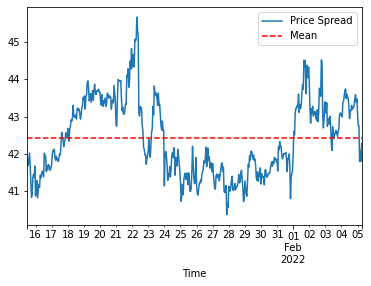

In [71]:
spread.plot() # Plot the spread
plt.axhline(spread.mean(), color='red', linestyle='--') # Add the mean
plt.xlabel('Time')
plt.legend(['Price Spread', 'Mean'])

In [72]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

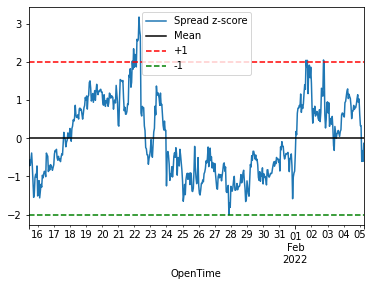

In [74]:
zscore(spread).plot()
plt.axhline(zscore(spread).mean(), color='black')
plt.axhline(2.0, color='red', linestyle='--')
plt.axhline(-2.0, color='green', linestyle='--')
plt.legend(['Spread z-score', 'Mean', '+1', '-1'])